In [1]:
import math
import os
import gc
import sys
import time

from pathlib import Path

from functools import partial
from typing import Callable, Dict, Iterator, List, Optional, Tuple, Union

from tqdm.notebook import tqdm

In [2]:
BASE_DIR = '/home/dmitry/projects/dfdc'
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')
HDF5_DIR = '/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5'

In [3]:
import cv2
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import Tensor

In [4]:
# src
sys.path.insert(0, os.path.join(BASE_DIR, 'src'))
from dataset.utils import read_labels
from prepare_data import get_file_list

In [5]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [6]:
def check_len_hdf5(path):
    lens = dict()
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        if os.path.isfile(full_path):
            with h5py.File(full_path, 'r+') as f:
                lens[name] = len(f)
    return lens

In [7]:
# path = '/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_17/'
# path += 'rbfvimgnid.h5'
# num_frames = 10
# sample_fn = partial(space_frames_evenly, num_frames)
# cols = math.ceil(num_frames / 6)
# faces = read_hdf5(path, num_frames=num_frames, sample_fn=sample_fn)        
# show_images(faces, cols=cols)

In [8]:
# check_len_hdf5('/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_48')

In [9]:
def find_num_frames(df, idxs):
    lens = []
    for idx in idxs:
        meta = df.iloc[idx]
        path = os.path.join(HDF5_DIR, meta.dir, meta.name[:-4]+'.h5')
        if os.path.isfile(path):
            with h5py.File(path, 'r+') as f:
                lens.append(len(f))
        else:
            lens.append(-1)
    return lens

In [10]:
def read_hdf5(path: str, num_frames: int, size: int,
              sample_fn: Callable[[int], np.ndarray]) -> np.ndarray:
    img_size = (size, size)
    images = []
    with h5py.File(path, 'r+') as file:
        total_frames = len(file)
        if total_frames > 0:
            idxs = sample_fn(total_frames)
            pick = create_mask(idxs, total_frames)
            for i, key in enumerate(file.keys()):
                if pick[i]:
                    img = np.uint8(file[key])
                    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size, 
                                     interpolation=cv2.INTER_NEAREST)
                    images.append(img)
            return np.stack(images)
        else:
            return np.empty((0, size, size, 3), dtype=np.uint8)
        
        
def sparse_frames(n: int, total: int) -> np.ndarray:
    idxs = np.linspace(0, total, min(n, total), dtype=int, endpoint=False)
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def rnd_slice_frames(n: int, total: int, stride=1) -> np.ndarray:
    idxs = np.arange(0, total, stride)[:n]
    rnd_shift = np.random.randint(0, (total - idxs[-1]))
    return idxs + rnd_shift


def create_mask(idxs: np.ndarray, total: int) -> np.ndarray:
    mask = np.zeros(total, dtype=np.bool)
    mask[idxs] = 1
    return mask


def pad(frames: np.ndarray, amount: int, where :str='start') -> np.ndarray:
    dims = np.zeros((frames.ndim, 2), dtype=np.int8)
    pad_dim = 1 if where == 'end' else 0
    dims[0, pad_dim] = amount
    return np.pad(frames, dims, 'constant')

In [11]:
class FrameSampler():
    def __init__(self, num_frames: int, real_fake_ratio: int, 
                 p_sparse: float):
        self.num_frames = num_frames
        self.real_fake_ratio = real_fake_ratio
        self.p_sparse = p_sparse
        
    def __call__(self, label: Tuple[int, bool]) -> Callable[[int], np.ndarray]:
        dice = np.random.rand()
        if dice < self.p_sparse:
            return partial(sparse_frames, self.num_frames)
        else:
            # Stored frames: fake - 30, real - 150, 
            # the real_fake_ratio should be set to 150 / 30 = 5
            # stride for fake: 5 - (4 * 1) = 1
            # stride for real: 5 - (4 * 0) = 5
            n = self.real_fake_ratio
            stride = n - ((n-1) * int(label))
            return partial(rnd_slice_frames, self.num_frames, stride=stride)

In [12]:
sampler = FrameSampler(num_frames=10, real_fake_ratio=5, p_sparse=0.)

In [13]:
sampler(1)(30)

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [14]:
sampler(0)(150)

array([ 73,  78,  83,  88,  93,  98, 103, 108, 113, 118])

In [15]:
frames = sampler(0)(125)
assert len(frames) == 10 
assert frames[-1] == frames[0] + (len(frames)-1) * 5
frames

array([46, 51, 56, 61, 66, 71, 76, 81, 86, 91])

In [16]:
sampler = FrameSampler(num_frames=10, real_fake_ratio=5, p_sparse=1.)

In [17]:
sampler(label=1)(30)

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28])

In [18]:
sampler(label=False)(150)

array([  9,  24,  39,  54,  69,  84,  99, 114, 129, 144])

In [19]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, data_path: str, hdf5_path: str, 
                 size: Tuple[int, int], 
                 sampler: FrameSampler):
        self.df = VideoDataset._read_annotations(data_path, hdf5_path)
        self.size = size
        self.hdf5_path = hdf5_path
        self.sampler = sampler
        
    @staticmethod
    def _read_annotations(data_path: str, hdf5_path: str) -> pd.DataFrame:
        if not os.path.isdir(data_path):
            raise RuntimeError('Invalid data dir.. Wake up your drive brah!')
        parts = []
        for chunk_dir in os.listdir(data_path):
            meta_path = Path(data_path)/chunk_dir/'metadata.json'
            df = pd.read_json(meta_path).T
            df['dir'] = chunk_dir
            df['label'] = df['label'] == 'FAKE'
            df['missing'] = False
            hdf5_chunk_path = Path(hdf5_path)/chunk_dir
            if not hdf5_chunk_path.is_dir():
                print('{}: dir is missing..'.format(hdf5_chunk_path))
                continue
            for file in df.index:
                hdf5_file = file[:-4]+'.h5'
                path = hdf5_chunk_path/hdf5_file
                if not path.is_file():
                    df.loc[file, 'missing'] = True
            num_miss = df['missing'].sum()
            if num_miss > 0:
                print('{}: {} files missing..'.format(
                    hdf5_chunk_path, num_miss))
                df = df[~df['missing']]
            df.drop(['split', 'missing'], axis=1, inplace=True)
            parts.append(df)
        return pd.concat(parts)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        num_frames, size = self.size
        meta = self.df.iloc[idx]
        path = os.path.join(self.hdf5_path, meta.dir, meta.name[:-4]+'.h5')
        
        if os.path.isfile(path):
            sample_fn = self.sampler(meta.label)
            frames = read_hdf5(path, num_frames, size, sample_fn=sample_fn)
        else:
            print('Unable to read {}'.format(path))
            return None, None
        
        if len(frames) > 0:
            pad_amount = num_frames - len(frames)
            if pad_amount > 0:
                frames = pad(frames, pad_amount, 'start')
            return frames, int(meta.label)
        else:
            print('Empty file {}'.format(path))
            return None, None

In [20]:
%%time
num_frames = 15
sampler = FrameSampler(num_frames, real_fake_ratio=1, p_sparse=0.5)
ds = VideoDataset(DATA_DIR, HDF5_DIR, size=(num_frames, 250), sampler=sampler)

/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_43: 2446 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_22: 1 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_33: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_41: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_29: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_27: 2255 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_23: 18 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_48: 1963 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_35: dir is missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_49: 3134 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf5/dfdc_train_part_7: 1 files missing..
/home/dmitry/projects/dfdc/data/dfdc-crops/hdf

In [21]:
dl = torch.utils.data.DataLoader(ds, batch_size=12, shuffle=True)
data_iter = iter(dl)

In [22]:
videos, labels = next(data_iter)

In [23]:
videos.shape, labels

(torch.Size([12, 15, 250, 250, 3]),
 tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]))

In [24]:
i = 0

Frame: 0


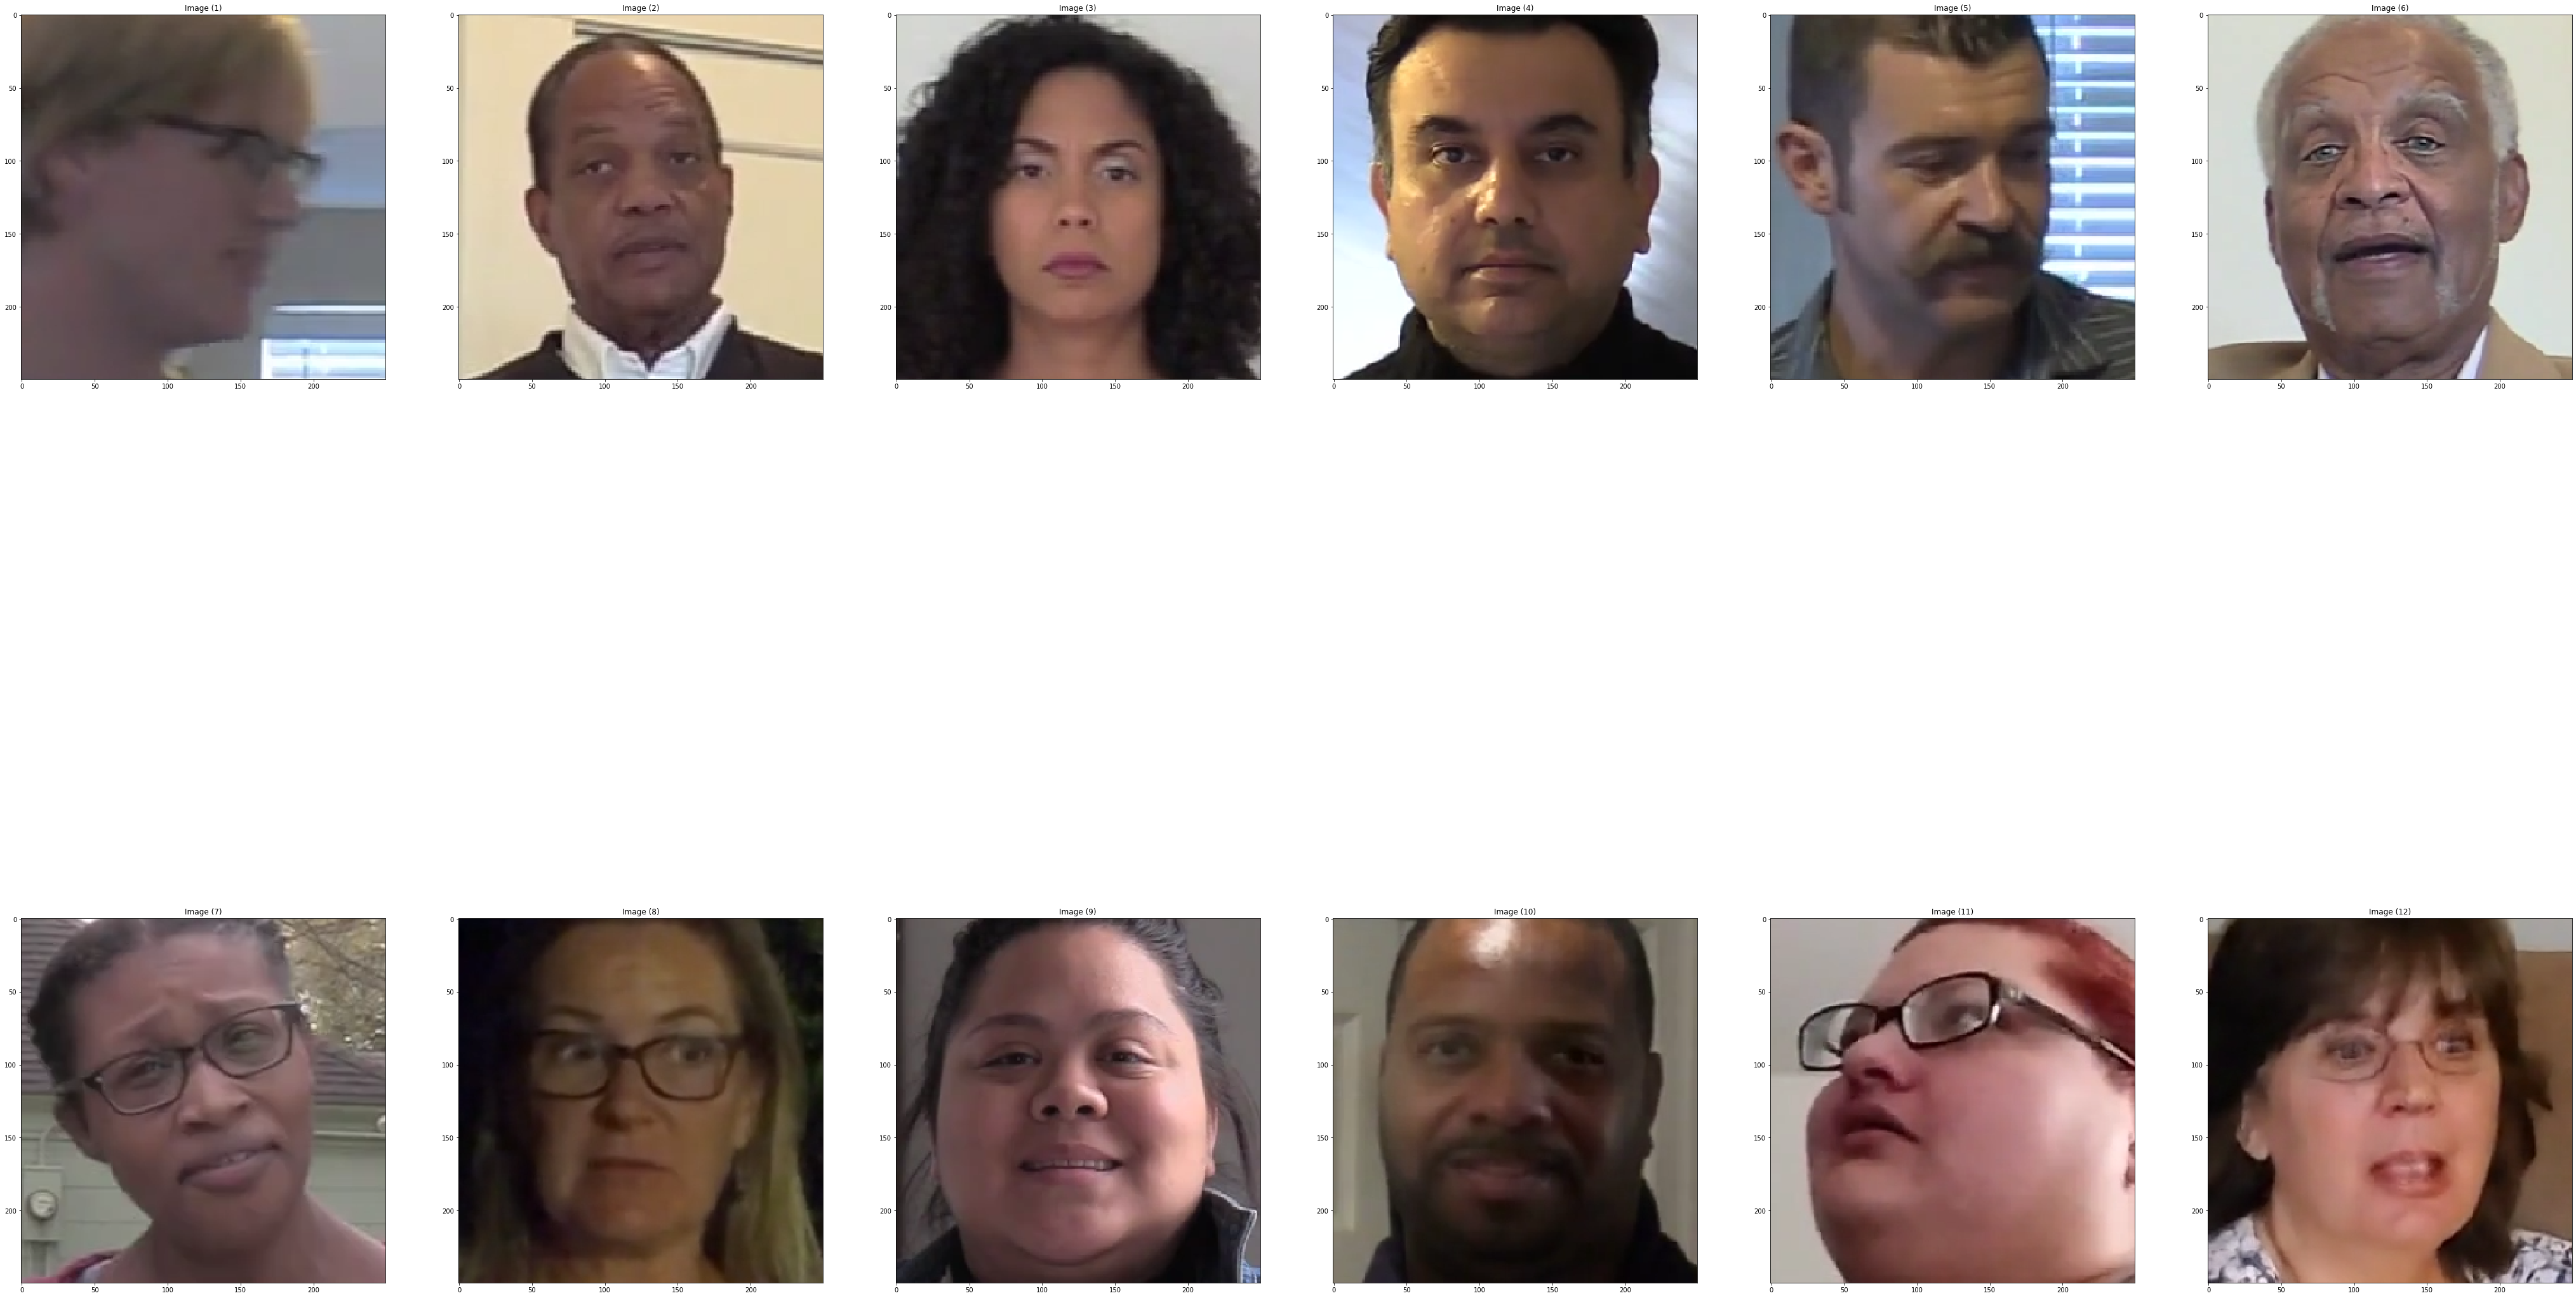

In [25]:
print(f'Frame: {i}')
ith_frames = videos[:,i].numpy()
cols = math.ceil(len(ith_frames)/6)
show_images(ith_frames, cols=cols)
i += 1

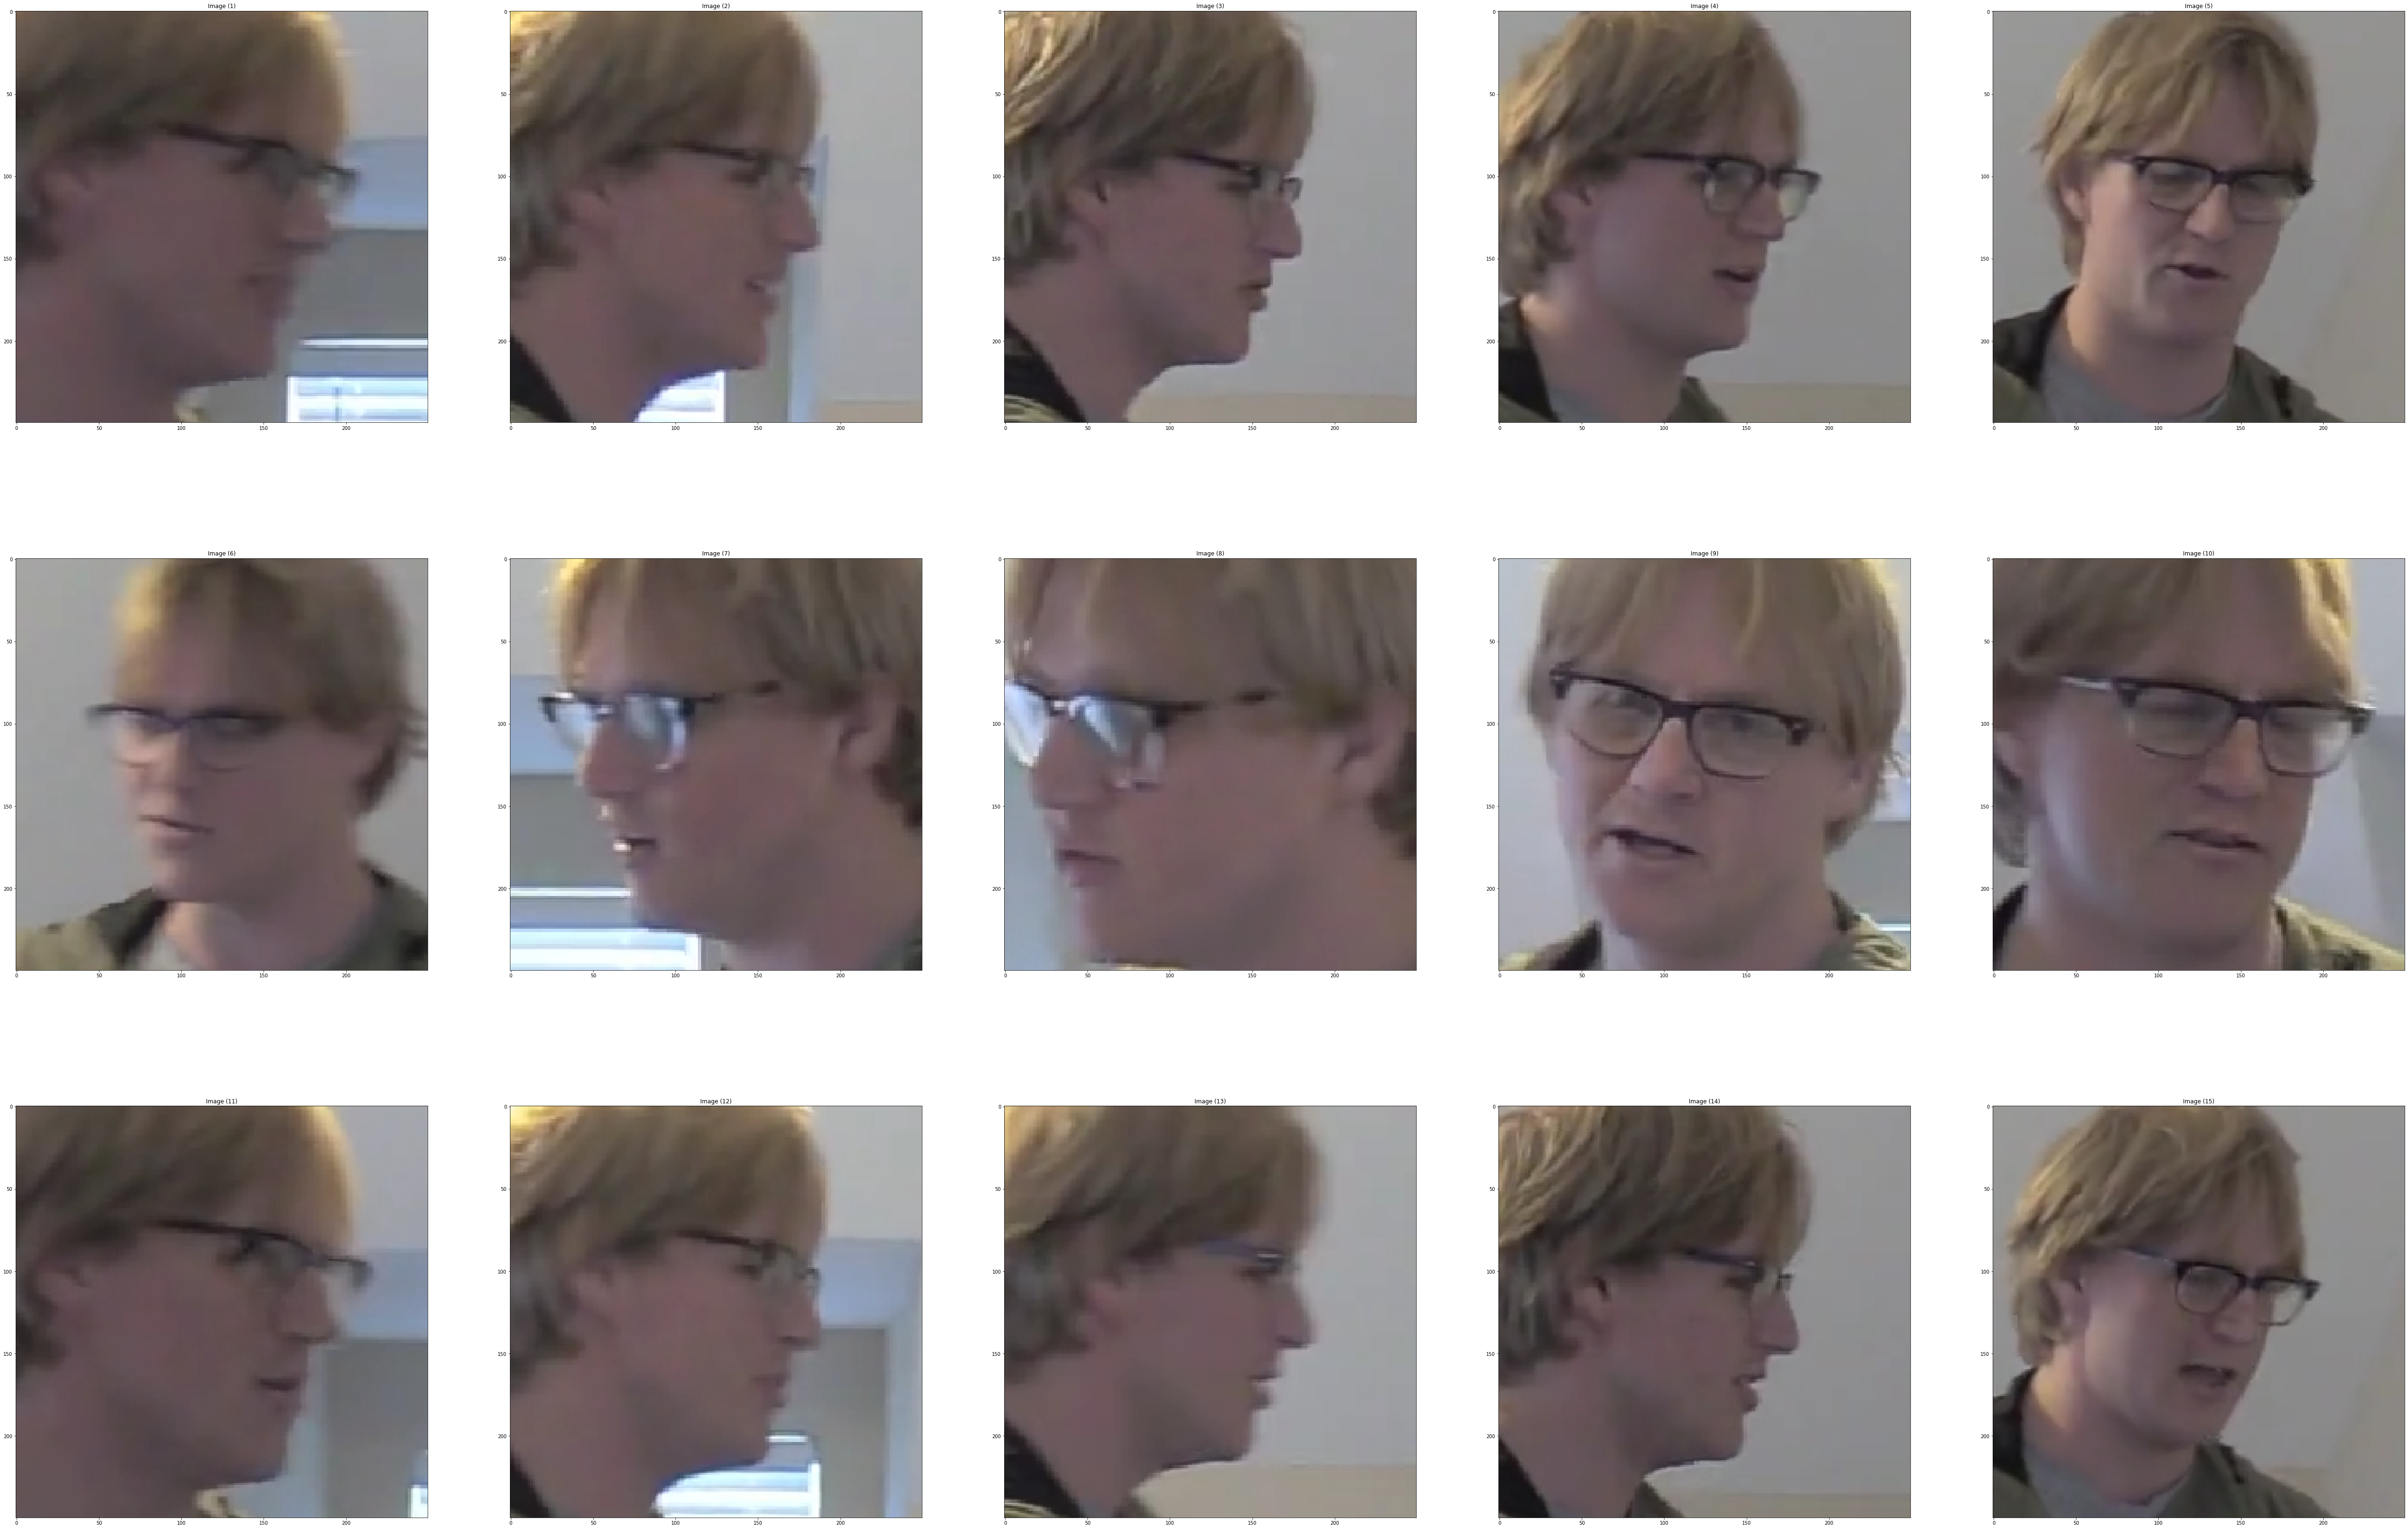

In [26]:
video = videos[0].numpy()
cols = math.ceil(len(video)/6)
show_images(video, cols=cols)